In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

from seaborn import histplot
import numpy as np

In [3]:
os.chdir('/data/rsg/nlp/sdobers/amine/diffdock-protein/src')

from evaluation.compute_rmsd import evaluate_all_rmsds, get_rmsd_summary

### define function

In [4]:
def read_eval_results(path_to_pkl):
    with open(path_to_pkl, "rb") as f:
        results = pickle.load(f)

    gt = [res[0][0] for res in results] # first elemnt is gt: as tuple (graph, conf_score)
    best_pred = [res[1][0] for res in results] # second elemnt is most confident prediction: as tuple (graph, conf_score)

    meter = evaluate_all_rmsds(gt, best_pred)
    
    return meter


In [5]:
def get_perfect_selection(path_to_pkl, topN=None):
    """
        if topN is None then perfect selction. else look for best result in topN confidenct predictions
    """
    with open(path_to_pkl, "rb") as f:
        results = pickle.load(f)
    
    n_complexes = len(results)
    
    if topN is None:
        topN = len(results[0]) - 1
    
    complex_rmsds_perfect_selection = np.full(n_complexes, np.inf)
    interface_rmsds_perfect_selection = np.full(n_complexes, np.inf)
    gt = [res[0][0] for res in results] # first elemnt is gt: as tuple (graph, conf_score)
    
    for i in range(1, topN+1):
        pred_i = [res[i][0] for res in results] # second elemnt is most confident prediction: as tuple (graph, conf_score)
        meter = evaluate_all_rmsds(gt, pred_i)

        complex_rmsds_i = np.array(meter.complex_rmsd_list)
        interface_rmsds_i = np.array(meter.interface_rmsd_list)
                
        complex_rmsds_perfect_selection = np.minimum(complex_rmsds_perfect_selection, complex_rmsds_i)
        interface_rmsds_perfect_selection = np.minimum(interface_rmsds_perfect_selection, interface_rmsds_i)
        
    print(f'Complex RMSD perfect selection: {get_rmsd_summary(complex_rmsds_perfect_selection)}')
    print(f'Interface RMSD perfect selection: {get_rmsd_summary(interface_rmsds_perfect_selection)}')
    return complex_rmsds_perfect_selection, interface_rmsds_perfect_selection


### DIPS - 40 samples - Large

In [16]:
# old: January
#PATH_dips_40s_large = '/data/rsg/nlp/sdobers/cedrik/diffdock-protein/storage/dips_esm_inference_40samples_large.pkl'

# 06.02.2023
PATH_dips_40s_large = '/data/rsg/nlp/sdobers/amine/diffdock-protein/storage/largest_model_140_epochs/dips_test_40s_lowtemp.pkl'


In [7]:
meter_dips_40s_large = read_eval_results(PATH_dips_40s_large)

In [8]:
_ = meter_dips_40s_large.summarize()

ligand_rmsd_summarized: {'mean': 26.74414, 'median': 13.107149, 'std': 28.801924, 'lt1': 10.0, 'lt2': 24.0, 'lt5': 42.0, 'lt10': 48.0}
complex_rmsd_summarized: {'mean': 10.330984311226638, 'median': 4.8471291065216064, 'std': 10.697554321798147, 'lt1': 27.0, 'lt2': 42.0, 'lt5': 50.0, 'lt10': 55.0}
interface_rmsd_summarized: {'mean': 8.690324251985599, 'median': 4.226316452026367, 'std': 10.477213459163817, 'lt1': 34.0, 'lt2': 45.0, 'lt5': 52.0, 'lt10': 63.0}


In [ ]:
histplot(data=meter_dips_40s_large.complex_rmsd_list, binwidth=1).set(title='DIPS Large - 40 samples', xlabel='Complex RMSD')


In [9]:
# oracle
_ = get_perfect_selection(PATH_dips_40s_large, topN=None)

Complex RMSD perfect selection: {'mean': 3.7951642025967876, 'median': 0.6741219758987427, 'std': 6.599484358205282, 'lt1': 60.0, 'lt2': 71.0, 'lt5': 79.0, 'lt10': 86.0}
Interface RMSD perfect selection: {'mean': 2.7353904272554512, 'median': 0.5395808517932892, 'std': 5.286926145160148, 'lt1': 65.0, 'lt2': 72.0, 'lt5': 82.0, 'lt10': 91.0}


In [ ]:
_ = get_perfect_selection(PATH_dips_40s_large, topN=5)

In [ ]:
_ = get_perfect_selection(PATH_dips_40s_large, topN=10)

### DIPS - 1 sample - Large

In [14]:
PATH_dips_1s_large = '/data/rsg/nlp/sdobers/amine/diffdock-protein/storage/largest_model_140_epochs/dips_test_1s_lowtemp.pkl'


In [17]:
# to get gt
with open(PATH_dips_40s_large, "rb") as f:
    results_40s = pickle.load(f)
gt = [res[0][0] for res in results_40s]

In [6]:
def get_averaged_1s_performance(path_to_pkl, gt):
    with open(path_to_pkl, "rb") as f:
        results_1s = pickle.load(f)
        
    lig_rmsd = []
    complex_rmsd = []
    interface_rmsd = []
    for res in results_1s:
        meter = evaluate_all_rmsds(gt, res)
        ligand_rmsd_summarized, complex_rmsd_summarized, interface_rmsd_summarized = meter.summarize(verbose=False)
        lig_rmsd.append(ligand_rmsd_summarized)
        complex_rmsd.append(complex_rmsd_summarized)
        interface_rmsd.append(interface_rmsd_summarized)

    print('Complex RMSD:')
    for k in complex_rmsd[0].keys():
        print(f'{k}:')
        print(np.mean([d[k] for d in complex_rmsd]))
        print('----')

    print('Interface RMSD:')
    for k in interface_rmsd[0].keys():
        print(f'{k}:')
        print(np.mean([d[k] for d in interface_rmsd]))
        print('----')

In [29]:
get_averaged_1s_performance(PATH_dips_1s_large, gt)

Complex RMSD:
mean:
12.425067660747656
----
median:
11.950200536191284
----
std:
12.565292784763955
----
lt1:
26.4
----
lt2:
34.2
----
lt5:
41.0
----
lt10:
45.6
----
Interface RMSD:
mean:
10.730562676544576
----
median:
8.60205808311513
----
std:
12.46997453576611
----
lt1:
28.2
----
lt2:
35.8
----
lt5:
41.6
----
lt10:
52.8
----


### DIPS - 40 samples mirrored - large

In [6]:
PATH_dips_40s_mirrored_large = '/data/rsg/nlp/sdobers/amine/diffdock-protein/storage/dips_mirror_esm_inference_40samples_large.pkl'


In [8]:
meter_dips_40s_mirrored_large = read_eval_results(PATH_dips_40s_mirrored_large)

In [9]:
_ = meter_dips_40s_mirrored_large.summarize()

ligand_rmsd_summarized: {'mean': 36.09284, 'median': 35.878654, 'std': 25.483225, 'lt1': 2.0, 'lt2': 11.0, 'lt5': 18.0, 'lt10': 22.0}
complex_rmsd_summarized: {'mean': 15.763235607879546, 'median': 16.642648696899414, 'std': 10.15655816895849, 'lt1': 13.0, 'lt2': 18.0, 'lt5': 22.0, 'lt10': 31.0}
interface_rmsd_summarized: {'mean': 16.759245638095347, 'median': 16.365045070648193, 'std': 12.70789654376828, 'lt1': 16.0, 'lt2': 20.0, 'lt5': 22.0, 'lt10': 35.0}


### DIPS - 10 samples - Large

In [15]:
PATH_dips_10s_large = '/data/rsg/nlp/sdobers/cedrik/diffdock-protein/storage/dips_esm_inference_10samples_large.pkl'

In [16]:
meter_dips_10s_large = read_eval_results(PATH_dips_10s_large)

In [17]:
_ = meter_dips_10s_large.summarize()

ligand_rmsd_summarized: {'mean': 32.97904, 'median': 33.13714, 'std': 29.957193, 'lt1': 7.0, 'lt2': 17.0, 'lt5': 31.0, 'lt10': 38.0}
complex_rmsd_summarized: {'mean': 12.876473048634935, 'median': 12.593231201171875, 'std': 11.481786117629763, 'lt1': 23.0, 'lt2': 31.0, 'lt5': 40.0, 'lt10': 46.0}
interface_rmsd_summarized: {'mean': 11.047447171517533, 'median': 10.044833183288574, 'std': 11.139125768275223, 'lt1': 23.0, 'lt2': 35.0, 'lt5': 42.0, 'lt10': 50.0}


[Text(0.5, 1.0, 'DIPS Large - 10 samples'), Text(0.5, 0, 'Complex RMSD')]

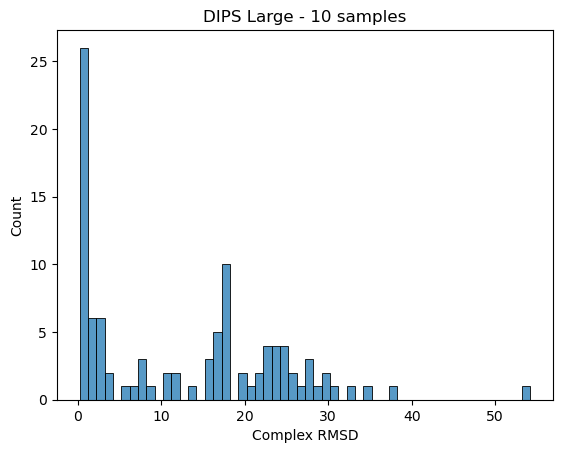

In [18]:
histplot(data=meter_dips_10s_large.complex_rmsd_list, binwidth=1).set(title='DIPS Large - 10 samples', xlabel='Complex RMSD')


### DIPS - 40 samples - Medium

In [10]:
PATH_dips_40s_medium = '/data/rsg/nlp/sdobers/cedrik/diffdock-protein/storage/dips_esm_inference_40samples_medium.pkl'

In [11]:
meter_dips_40s_medium = read_eval_results(PATH_dips_40s_medium)

In [12]:
_ = meter_dips_40s_medium.summarize()

ligand_rmsd_summarized: {'mean': 32.990433, 'median': 33.898064, 'std': 30.310276, 'lt1': 3.0, 'lt2': 17.0, 'lt5': 35.0, 'lt10': 40.0}
complex_rmsd_summarized: {'mean': 12.747284137310643, 'median': 12.340553283691406, 'std': 11.268931665648982, 'lt1': 23.0, 'lt2': 35.0, 'lt5': 40.0, 'lt10': 45.0}
interface_rmsd_summarized: {'mean': 11.375788321804016, 'median': 9.96599531173706, 'std': 11.749855493980782, 'lt1': 27.0, 'lt2': 37.0, 'lt5': 40.0, 'lt10': 50.0}


[Text(0.5, 1.0, 'DIPS Medium - 40 samples'), Text(0.5, 0, 'Complex RMSD')]

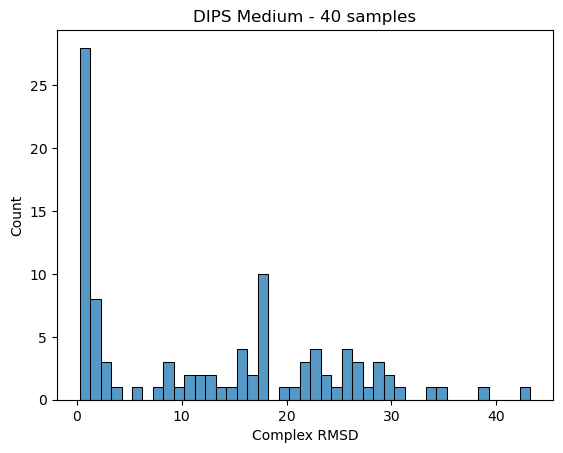

In [13]:
histplot(data=meter_dips_40s_medium.complex_rmsd_list, binwidth=1).set(title='DIPS Medium - 40 samples', xlabel='Complex RMSD')


### DB5 - bound - 40 samples - Large

In [25]:
PATH_db5_bound_40s_large = '/data/rsg/nlp/sdobers/amine/diffdock-protein/storage/db5_bound_esm_inference_40samples_large.pkl'


In [26]:
meter_db5_bound_40s_large = read_eval_results(PATH_db5_bound_40s_large)

In [27]:
_ = meter_db5_bound_40s_large.summarize()

ligand_rmsd_summarized: {'mean': 55.954212, 'median': 52.766087, 'std': 25.952457, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 4.0}
complex_rmsd_summarized: {'mean': 20.046983742374067, 'median': 18.188993453979492, 'std': 8.881557478330702, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 4.0, 'lt10': 8.0}
interface_rmsd_summarized: {'mean': 21.781913623296663, 'median': 19.295351028442383, 'std': 10.452768944146692, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 8.0}


##### perfect selection

In [40]:
_ = get_perfect_selection(PATH_db5_bound_40s_large, None)

Complex RMSD perfect selection: {'mean': 8.064637537002563, 'median': 7.4175310134887695, 'std': 3.442530585250299, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 20.0, 'lt10': 72.0}
Interface RMSD perfect selection: {'mean': 7.570098815925768, 'median': 7.525291442871094, 'std': 2.918526779127169, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 20.0, 'lt10': 80.0}


### DB5 - unbound - 40 samples - Large

In [13]:
# old January
#PATH_db5_unbound_40s_large = '/data/rsg/nlp/sdobers/amine/diffdock-protein/storage/db5_unbound_esm_inference_40samples_large.pkl'

# 06.02.2023
PATH_db5_unbound_40s_large = '/data/rsg/nlp/sdobers/amine/diffdock-protein/storage/largest_model_140_epochs/db5_unbound_test_40s_lowtemp.pkl'


In [14]:
meter_db5_unbound_40s_large = read_eval_results(PATH_db5_unbound_40s_large)

In [15]:
_ = meter_db5_unbound_40s_large.summarize()

ligand_rmsd_summarized: {'mean': 46.30551, 'median': 43.038536, 'std': 17.300772, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 0.0}
complex_rmsd_summarized: {'mean': 17.81402389629212, 'median': 18.95971548544824, 'std': 6.169919481772681, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 12.0}
interface_rmsd_summarized: {'mean': 19.24510439849215, 'median': 18.23585114659313, 'std': 7.513456009040927, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 8.0}


##### perfect selection

In [16]:
_ = get_perfect_selection(PATH_db5_unbound_40s_large)

Complex RMSD perfect selection: {'mean': 10.140596456206913, 'median': 8.831104278564453, 'std': 5.308608007512469, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 16.0, 'lt10': 56.0}
Interface RMSD perfect selection: {'mean': 8.859352645349663, 'median': 9.287496566772461, 'std': 3.2350236950471163, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 12.0, 'lt10': 56.0}


#### 1 sample

In [17]:
with open(PATH_db5_unbound_40s_large, "rb") as f:
    results_for_gt = pickle.load(f)

gt_db5_unbound = [res[0][0] for res in results_for_gt] # first elemnt is gt: as tuple (graph, conf_score)


In [19]:
PATH_db5_unbound_1s_large = '/data/rsg/nlp/sdobers/amine/diffdock-protein/storage/largest_model_140_epochs/db5_unbound_test_1s_lowtemp.pkl'


In [20]:
get_averaged_1s_performance(PATH_db5_unbound_1s_large, gt_db5_unbound)

Complex RMSD:
mean:
17.440108851902885
----
median:
16.423452519519252
----
std:
6.860359548345118
----
lt1:
0.0
----
lt2:
0.0
----
lt5:
1.6
----
lt10:
9.6
----
Interface RMSD:
mean:
18.765867448359785
----
median:
16.70218733328962
----
std:
8.429249714051489
----
lt1:
0.0
----
lt2:
0.0
----
lt5:
0.0
----
lt10:
12.8
----


### DB5 - unbound - 40 samples - large - no confidence

In [4]:
PATH_db5_unbound_40s_large_no_confidence = '/data/rsg/nlp/sdobers/amine/diffdock-protein/storage/db5_unbound_no_confidence_40samples_large.pkl'


In [5]:
with open(PATH_db5_unbound_40s_large_no_confidence, "rb") as f:
    results_no_confidence = pickle.load(f)


In [7]:
len(results_no_confidence[0])

25

In [13]:
complex_rmsds_perfect_selection = np.full(25, np.inf)
ligand_rmsds_perfect_selection = np.full(25, np.inf)
for i, results_run_i in enumerate(results_no_confidence):
    meter = evaluate_all_rmsds(gt_db5_unbound, results_run_i)
    complex_rmsds_perfect_selection = np.minimum(complex_rmsds_perfect_selection, np.array(meter.complex_rmsd_list))
    ligand_rmsds_perfect_selection = np.minimum(ligand_rmsds_perfect_selection, np.array(meter.ligand_rmsd_list))

    print(f'Run {i}:')
    _ = meter.summarize()
    print('-------------------------------')
print(f'Complex RMSD perfect selection: {get_rmsd_summary(complex_rmsds_perfect_selection)}')
print('-------------------------------')
print(f'Ligand RMSD perfect selection: {get_rmsd_summary(ligand_rmsds_perfect_selection)}')

Run 0:
ligand_rmsd_summarized: {'mean': 50.566597, 'median': 53.210545, 'std': 19.846611, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 0.0}
complex_rmsd_summarized: {'mean': 18.862876583795327, 'median': 19.537390594454823, 'std': 7.1047574110867515, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 16.0}
interface_rmsd_summarized: {'mean': 19.764899190246837, 'median': 16.68893372455951, 'std': 9.850536790933159, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 12.0}
-------------------------------
Run 1:
ligand_rmsd_summarized: {'mean': 51.79168, 'median': 51.418472, 'std': 21.134943, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 0.0}
complex_rmsd_summarized: {'mean': 18.24651627172168, 'median': 18.018024444580078, 'std': 6.714920844729005, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 12.0}
interface_rmsd_summarized: {'mean': 20.613041777352226, 'median': 18.958949314260515, 'std': 8.813973609760138, 'lt1': 0.0, 'lt2': 0.0, 'lt5': 0.0, 'lt10': 12.0}
-------------------------------
Run 2:
ligand_rm